In [19]:
##Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [20]:
class util:
    def add_intercept(x):
        """Add intercept to matrix x.

        Args:
            x: 2D NumPy array.

        Returns:
            New matrix same as x with 1's in the 0th column.
        """
        new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
        new_x[:, 0] = 1
        new_x[:, 1:] = x

        return new_x
    
    ##Also can be done easily using Pandas like Linear Regression
    def load_dataset(csv_path, label_col='y', add_intercept=False):
        """Load dataset from a CSV file.

        Args:
             csv_path: Path to CSV file containing dataset.
             label_col: Name of column to use as labels (should be 'y' or 'l').
             add_intercept: Add an intercept entry to x-values.

        Returns:
            xs: Numpy array of x-values (inputs).
            ys: Numpy array of y-values (labels).
        """

        def add_intercept_fn(x):
            global add_intercept
            return util.add_intercept(x)

        # Validate label_col argument
        allowed_label_cols = ('y', 't')
        if label_col not in allowed_label_cols:
            raise ValueError('Invalid label_col: {} (expected {})'
                             .format(label_col, allowed_label_cols))

        # Load headers
        with open(csv_path, 'r') as csv_fh:
            headers = csv_fh.readline().strip().split(',')

        # Load features and labels
        x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
        l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
        inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
        labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

        if inputs.ndim == 1:
            inputs = np.expand_dims(inputs, -1)

        if add_intercept:
            inputs = add_intercept_fn(inputs)

        return inputs, labels
    
    def plot(x, y, theta, save_path, correction=1.0):
        """Plot dataset and fitted logistic regression parameters.

        Args:
            x: Matrix of training examples, one per row.
            y: Vector of labels in {0, 1}.
            theta: Vector of parameters for logistic regression model.
            save_path: Path to save the plot.
            correction: Correction factor to apply (Problem 2(e) only).
        """
        # Plot dataset
        plt.figure()
        plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
        plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

        # Plot decision boundary (found by solving for theta^T x = 0)
        x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
        x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
        plt.plot(x1, x2, c='red', linewidth=2)

        # Add labels and save to disk
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.savefig(save_path)
    

In [21]:
a = np.random.randint(0,10,size = (3,4))
print(a,'\n\n')
a = util.add_intercept(a)
print(a)

[[9 1 8 1]
 [1 7 5 7]
 [5 1 7 0]] 


[[1 9 1 8 1]
 [1 1 7 5 7]
 [1 5 1 7 0]]


(800, 2) (800,)


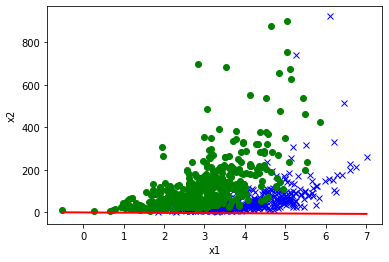

In [22]:
x,y = util.load_dataset('../data/ds1_train.csv')
print(x.shape,y.shape)
util.plot(x,y,theta=[0.1,0.1,0.1],save_path='../output/output.png')

In [23]:
## Interface with abstract methods
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')


In [38]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver."""

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        
        m, n = x.shape  ##Size of training set , size of theta
        
        # initialize theta (Zeros)
        if self.theta is None:
            self.theta = np.zeros(n)
            
        ##Canonical Response function for Logistic Reg    
        g = lambda x: 1 / (1 + np.exp(-x))
        

        while True:##Repeat Untill Convergence
            theta = self.theta 
            theta_T_x = x @ theta
            dJ = - (1 / m) * (y - g(theta_T_x)) @ x# compute Cost wrt parameter(theta)
                 
            
            H = (1 / m) * g(theta_T_x).dot(g(1 - theta_T_x)) * x.T @ x #Hession 
            H_inv = np.linalg.inv(H) #Inverse of hession (Costly computation)
            
            self.theta = theta - H_inv.dot(dJ) #Use the newtons raphson method 
            if np.linalg.norm(self.theta - theta, ord=1) < self.eps:###repeat until derivative or theta is as low as eps
                break
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        # Test time: h(x) gives the prediction on an input
        g = lambda x: 1 / (1 + np.exp(-x))
        theta_T_x = x @ self.theta
        preds = g(theta_T_x)
        
        return preds
        # *** END CODE HERE ***

Time :  28.015625 s


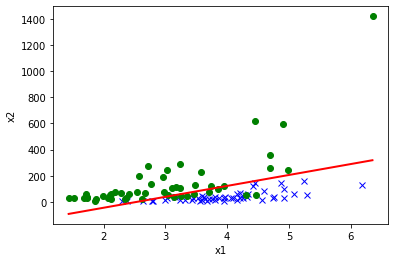

In [39]:
if __name__ == '__main__':
    train_path = '../data/ds1_train.csv'
    eval_path = '../data/ds1_valid.csv'
    pred_path='../output/pred.txt'
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***
    start = time.process_time()
    model = LogisticRegression(eps=1e-5)# Instantiate the model, LogisticRegression in this case
    model.fit(x_train, y_train)## feed the data to model for training
    
    # Plot decision boundary 
    x_val, y_val = util.load_dataset(eval_path, add_intercept=True) #load the val set 
    y_pred = model.predict(x_val) ## do the precdicion on val set
    util.plot(x_val, y_val, model.theta, '{}.png'.format(pred_path)) ## Plot the data and decision boundary(util.plot)
    
    np.savetxt(pred_path, y_pred) ## Save the prediction made
    end = time.process_time()
    print('Time : ',end - start,'s')